单元测试：验证 `plcoding.channel` 模块是否工作正常

In [1]:
import numpy as np
import plcoding.channel as plchannel
from matplotlib import pyplot as plt
from tqdm import trange

In [2]:
# BPSK调制 + (N=1024, R=0.5)极化码
block_len = 1024
code_rate = 0.5
moder = plchannel.BPSK()
codec = plchannel.PolarCodec(block_len, code_rate)

In [3]:
# 在指定信噪比的AWGN信道下仿真
def simulate(snr_dB: float, _max_round: int=10000, _positive_count : int=10) -> float:
    awgn = plchannel.AWGN(noise_pwr = 10 ** (-snr_dB / 10))
    bler, _round = 0, 0
    while _round < _max_round:
        tx_bits = (np.random.rand(block_len) < 0.5).astype(int)
        tx_bits[codec.frozen] = 0
        tx_symbols = moder.modulate(codec.encode(tx_bits))
        rx_symbols = awgn.transmit(tx_symbols)
        rx_probs = moder.demodulate(rx_symbols, awgn)
        tx_bits_ = codec.sc_decode(rx_probs)
        bler += (tx_bits != tx_bits_).any()
        # 出现足够多次实验结果时早停
        _round += 1
        if bler > _positive_count:
            break
    return bler / _round

In [4]:
# 在一定信噪比范围内仿真多个点
snr_dBs = np.linspace(0, 5, 10)
blers = np.empty(snr_dBs.shape, dtype=float)
for i in trange(len(snr_dBs), ncols=80):
    blers[i] = simulate(snr_dBs[i])

100%|███████████████████████████████████████████| 10/10 [01:09<00:00,  6.96s/it]


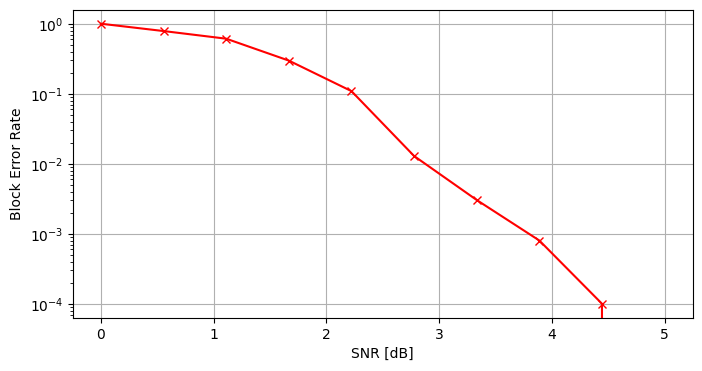

In [5]:
# 绘制曲线
plt.figure(figsize=(8, 4))
plt.semilogy(snr_dBs, blers, 'r-x')
plt.xlabel("SNR [dB]")
plt.ylabel("Block Error Rate")
plt.grid(); plt.show()